# TFG de Miguel Ángel

En este documento vamos a ir haciendo un pequeño análisis del TFG convenientemente documentado, que servirá en el futuro para poder realizar la memoria y el análisis completo.

## Datos

A continuación un sucinto resumen de cómo es la estructura de los datos

### ECGs

Los ECGs son de una única derivación (un canal), con una duración entre **9 segs a 60 segs**. 

* Una reflexión, para el esquema de clasificación sin utilizar las redes neuronales recurrentes, podríamos hacer que todas las series tuviesen la misma longitud, por ejemplo 60 seg, de tal forma que las más cortas se podrían generar replicando de alguna forma la serie para que tuviese 60 seg.

* La **frecuencia de muestreo** es de 300 Hz

* Los tipos de posibles señales son:
    1. Normal - N
    2. AF - A
    3. Otros ritmos - O
    4. Ruidoso - ~


### Training

La base de datos de training tiene la información de la clasificación del ritmo en los csv que están en la carpeta training. **Es necesario leer la cabecera, pero no continene la información de la clasificación**

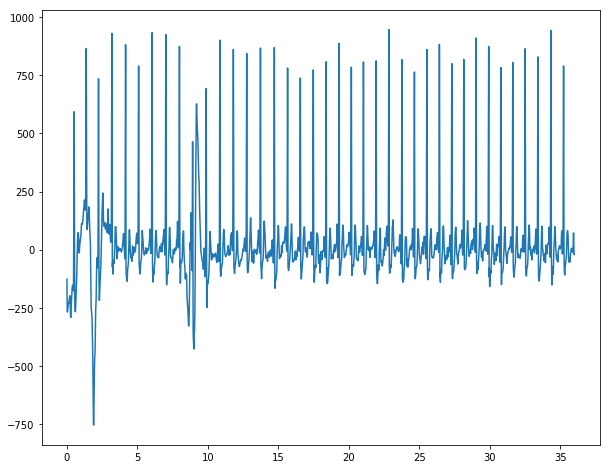

In [1]:
#Vamos a leer un par de ejemplo, así como la cabecera
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
from tfg_tools import read_challenge_mat_files, processing_ecg, plot_all_records

ecg, header = read_challenge_mat_files('A00001.mat','./')
fs = 250 #float(header['fs'])
t = np.arange(0,len(ecg))/fs 
plt.figure(figsize = (10,8))
plt.plot(t,ecg)

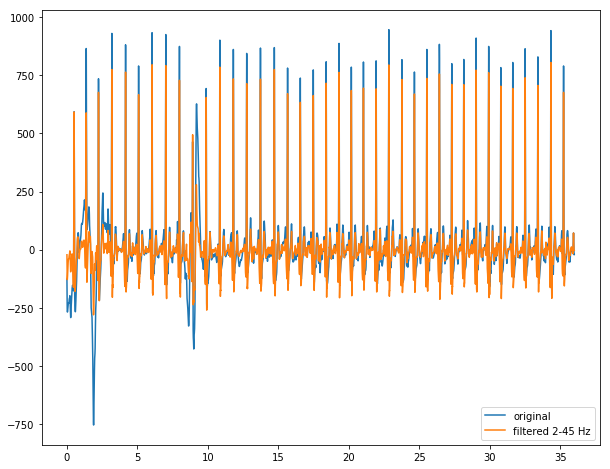

In [2]:
ecg_filtered = processing_ecg(ecg)

plt.figure(figsize = (10,8))
plt.plot(t,ecg,label='original')
plt.plot(t,ecg_filtered,label='filtered 2-45 Hz')
plt.legend()

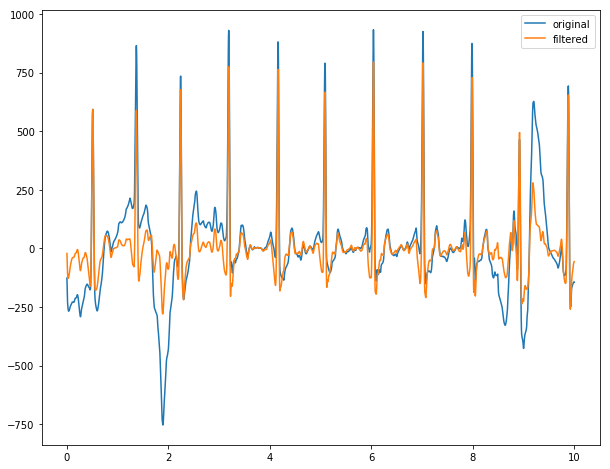

In [3]:
#zoom

plt.figure(figsize = (10,8))
plt.plot(t[t<10],ecg[t<10],label='original')
plt.plot(t[t<10],ecg_filtered[t<10],label='filtered')
plt.legend()

# Chapter Preprocesamiento y análisis exploratorio de señales

**TO DO**

* Crear una rutina que te pinte todas las señales. Un for que vaya pintando todas las señales y que se en la figura pinte información de los ejes (segundos y mv) y en la leyenda indique cómo ha sido clasificada la señal. Convendría pintar la señal original y la filtrada entre 2 y 45 Hz. Que no pase a la siguiente iteración del bucle hasta que, por ejemplo, se pulse un click de raton o alguna tecla.

* Sacar la siguiente información:
    * Número de sujetos en cada clase (esto lo puedes sacar del fichero en el que viene la clasificación de cada señal)
    * Longitudes de las señales: Una función que se cree un vector con todas las longitudes de todas las señales, y que pinte un histograma de las longitudes.
   
* Con esto podemos divisar los modeos de deep learning para clasificación


# NOTA:

<font color='red'>Miguel Ángel, lo que te pedía es que tu hicieses el análisis y completases este notebook con esa información, porque todo lo que escribas aquí, también se puede utilizar luego para la memoria</font>


### Número de sujetos en cada clase:

A continuación obtenemos el resultado de sujetos por cada clase:



In [4]:
#get the number of patietns in each class

from tfg_tools import get_distribution_classes

class_dist = get_distribution_classes()

print(class_dist)

{'A': 738, 'N': 5050, 'O': 2456, '~': 284}


Como se puede observar existe un claro desbalanceo: El caso de los registros normales es siete veces mayor que el caso de las señales con AF. Habrá que escoger alguna técnica de balanceado. Lo primero que recomendamos es echar un vistazo al siguiente post:

[Imbalanced classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

De las técnicas que tenemos en este caso, yo propondría varias, teniendo en cuenta que esto es un TFG:

1. Entrenar para mejorar otra métrica que accuracy, por ejemplo $\kappa$ o $F_1 score$.
2. Random over-sampling under-sampling: podemos utilizar el siguiente módulo (imbalanced-learning)(http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html)
3. Utilizar costes diferentes dependiendo de la misclassification

### Longitudes de las señales

Un problema cuando trabajamos con modelos que no tengan en cuenta la parte dinámica es la diferente longitud de las señales. Vamos a obtener un histograma de las diferentes longitudes de señales, para tener una idea del rango de posibles longitudes, para proponer una estrategia cuando implementemos el modelo de deep learning sin memoria

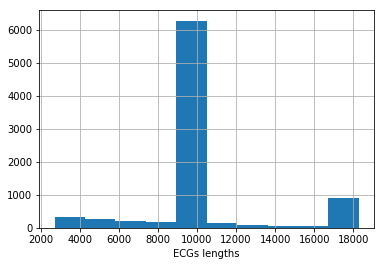

In [5]:
from tfg_tools import get_distribution_length

lengths = get_distribution_length()

In [6]:
#Número de señales con menos de 9000

print('El numero de senales con menos de 9000 es: ',np.sum(np.array(lengths)<9000))

El numero de senales con menos de 9000 es:  967


## TO-DO

Vamos a considerar **longitud de señales = 9000**, todas las que estén por debajo (967) no van a entrar en el conjunto, al menos en primera instancia. Necesitamos verificar de qué clase son las señales con menos de 9000. 

Tu próxima tarea es verificar las distribución por clases de esas 967 señales con menos de 9000. Para las que tienen más de 9000 muestras vamos a utilizar sólo las primeras 9000.

El problema lo resolver

In [7]:
from tfg_tools import get_distribution_less9000

classes_less_9000 = get_distribution_less9000()

print(classes_less_9000)



{'AF': 113, 'Noisy': 139, 'Normal': 521, 'Other Rhyth': 194}


Como podemos apreciar en los resultados de las señales con longitud menor de 9000, las señales normales son las más abundantes en comparanción con el resto. 

**Cuidado con estas afirmaciones Miguel Ángel** lo que dices es cierto, pero en valor absoluto, el problema es que no hay la misma cantidad inicial de datos, de hecho: AF 113/783 = 0.19 approx 20%, mientras que Normal 521/5050 = 0.10 approx 10%

De esta manera podemose decir que, para el caso de una NN sin memoria, con señales de entrada de longitud 9000 muestras, vamos a tener la siguiente distribución:

* **AF** = 738 - 113 = **625**
* **Noisy** = 284 - 139 = **145**
* **Other** = 2456 - 194 = **2262**
* **Normal** = 5050 - 521 = **4529**


## TO_DO

Los siguientes pasos serían:

1. Partir convenientemente los datos en training y test, yo utilizaría alguna herramienta de sklearn para mantener las proporciones (de las clases) en test, hay herramientas como stratified.
2. Elegir alguna estrategia para comenzar con el tratamiento del desbalanceo: por ejemplo: under-sampling, over-sampling (aquí, vamos a utilizar el modulo que puse anteriormente, parecido a sklearn), y métrica.
3. Constuir un esquema sencillo de red neuronal, y luego complicarlo.

In [8]:
#Example of stratified split into train and test 

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

x = np.ones(100)
y = [0,0,0,0,1,1,1,1,1,1] *10 #proportion of labels 6 out of 10 are class 1
y = np.array(y)

#split with previous shuffle. Test size = 33%

skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.33)

for train, test in skf.split(x,y):
    print("%s %s" % (train,test))

#let's check proportions

print("Proportion of class 1 in original dataset %.2f %%: " % (np.sum(y)/float(len(y))))
print("Proportion of class 1 in training dataset %.2f %%: " % (np.sum(y[train])/float(len(y[train]))))
print("Proportion of class 1 in test dataset %.2f %%: " % (np.sum(y[test])/float(len(y[test]))))

[79 47 12 69 31  7 50 71 84 16 40 52 85 59 57 93 67 54  2 24 92 60 35  9
 29 96 66 39 21 61 19 64 41 13 51 95 34 15 53 26 76 43 11 28 55 87 44 86
 97 65 45 27 83 73 23 70 18 46 88 82 80 77 90 72 33 25 74] [81 37 89 49 32  3 17 48  4 20 56 91 75  8 58 98 94 62  0 78 14 22  6 99
 68 10  1 63 42 38 30 36  5]
Proportion of class 1 in original dataset 0.60 %: 
Proportion of class 1 in training dataset 0.60 %: 
Proportion of class 1 in test dataset 0.61 %: 


## Chapter : Modelos de redes neuronales

Vamos a comenzar utilizando una red neuronal ..

$$y(t) = \frac{1}{x}$$

   ## Creación Matrix X y vector y
   
   En esta sección vamos a crear una matrix X con todos los casos con más de 9000 muestras. Pues vamos a elegir trabajar con señales de 9000 muestras. Una vez creadas estas matrices y vectores, los vamos a salvar en disco para trabajar más rápido con ellas. Esta va a ser nuestro conjunto de inicio.

In [9]:
from tfg_tools import filter_data

X,y = filter_data()

#convert to a code y
y_new = codify_y(y)

0 / 8528
1 / 8528
2 / 8528
3 / 8528
4 / 8528
5 / 8528
6 / 8528
7 / 8528
8 / 8528
9 / 8528
10 / 8528
11 / 8528
12 / 8528
13 / 8528
14 / 8528
15 / 8528
16 / 8528
17 / 8528
18 / 8528
19 / 8528
20 / 8528
21 / 8528
22 / 8528
23 / 8528
24 / 8528
25 / 8528
26 / 8528
27 / 8528
28 / 8528
29 / 8528
30 / 8528
31 / 8528
32 / 8528
33 / 8528
34 / 8528
35 / 8528
36 / 8528
37 / 8528
38 / 8528
39 / 8528
40 / 8528
41 / 8528
42 / 8528
43 / 8528
44 / 8528
45 / 8528
46 / 8528
47 / 8528
48 / 8528
49 / 8528
50 / 8528
51 / 8528
52 / 8528
53 / 8528
54 / 8528
55 / 8528
56 / 8528
57 / 8528
58 / 8528
59 / 8528
60 / 8528
61 / 8528
62 / 8528
63 / 8528
64 / 8528
65 / 8528
66 / 8528
67 / 8528
68 / 8528
69 / 8528
70 / 8528
71 / 8528
72 / 8528
73 / 8528
74 / 8528
75 / 8528
76 / 8528
77 / 8528
78 / 8528
79 / 8528
80 / 8528
81 / 8528
82 / 8528
83 / 8528
84 / 8528
85 / 8528
86 / 8528
87 / 8528
88 / 8528
89 / 8528
90 / 8528
91 / 8528
92 / 8528
93 / 8528
94 / 8528
95 / 8528
96 / 8528
97 / 8528
98 / 8528
99 / 8528
100 / 8528

756 / 8528
757 / 8528
758 / 8528
759 / 8528
760 / 8528
761 / 8528
762 / 8528
763 / 8528
764 / 8528
765 / 8528
766 / 8528
767 / 8528
768 / 8528
769 / 8528
770 / 8528
771 / 8528
772 / 8528
773 / 8528
774 / 8528
775 / 8528
776 / 8528
777 / 8528
778 / 8528
779 / 8528
780 / 8528
781 / 8528
782 / 8528
783 / 8528
784 / 8528
785 / 8528
786 / 8528
787 / 8528
788 / 8528
789 / 8528
790 / 8528
791 / 8528
792 / 8528
793 / 8528
794 / 8528
795 / 8528
796 / 8528
797 / 8528
798 / 8528
799 / 8528
800 / 8528
801 / 8528
802 / 8528
803 / 8528
804 / 8528
805 / 8528
806 / 8528
807 / 8528
808 / 8528
809 / 8528
810 / 8528
811 / 8528
812 / 8528
813 / 8528
814 / 8528
815 / 8528
816 / 8528
817 / 8528
818 / 8528
819 / 8528
820 / 8528
821 / 8528
822 / 8528
823 / 8528
824 / 8528
825 / 8528
826 / 8528
827 / 8528
828 / 8528
829 / 8528
830 / 8528
831 / 8528
832 / 8528
833 / 8528
834 / 8528
835 / 8528
836 / 8528
837 / 8528
838 / 8528
839 / 8528
840 / 8528
841 / 8528
842 / 8528
843 / 8528
844 / 8528
845 / 8528
846 / 8528

1461 / 8528
1462 / 8528
1463 / 8528
1464 / 8528
1465 / 8528
1466 / 8528
1467 / 8528
1468 / 8528
1469 / 8528
1470 / 8528
1471 / 8528
1472 / 8528
1473 / 8528
1474 / 8528
1475 / 8528
1476 / 8528
1477 / 8528
1478 / 8528
1479 / 8528
1480 / 8528
1481 / 8528
1482 / 8528
1483 / 8528
1484 / 8528
1485 / 8528
1486 / 8528
1487 / 8528
1488 / 8528
1489 / 8528
1490 / 8528
1491 / 8528
1492 / 8528
1493 / 8528
1494 / 8528
1495 / 8528
1496 / 8528
1497 / 8528
1498 / 8528
1499 / 8528
1500 / 8528
1501 / 8528
1502 / 8528
1503 / 8528
1504 / 8528
1505 / 8528
1506 / 8528
1507 / 8528
1508 / 8528
1509 / 8528
1510 / 8528
1511 / 8528
1512 / 8528
1513 / 8528
1514 / 8528
1515 / 8528
1516 / 8528
1517 / 8528
1518 / 8528
1519 / 8528
1520 / 8528
1521 / 8528
1522 / 8528
1523 / 8528
1524 / 8528
1525 / 8528
1526 / 8528
1527 / 8528
1528 / 8528
1529 / 8528
1530 / 8528
1531 / 8528
1532 / 8528
1533 / 8528
1534 / 8528
1535 / 8528
1536 / 8528
1537 / 8528
1538 / 8528
1539 / 8528
1540 / 8528
1541 / 8528
1542 / 8528
1543 / 8528
1544

2144 / 8528
2145 / 8528
2146 / 8528
2147 / 8528
2148 / 8528
2149 / 8528
2150 / 8528
2151 / 8528
2152 / 8528
2153 / 8528
2154 / 8528
2155 / 8528
2156 / 8528
2157 / 8528
2158 / 8528
2159 / 8528
2160 / 8528
2161 / 8528
2162 / 8528
2163 / 8528
2164 / 8528
2165 / 8528
2166 / 8528
2167 / 8528
2168 / 8528
2169 / 8528
2170 / 8528
2171 / 8528
2172 / 8528
2173 / 8528
2174 / 8528
2175 / 8528
2176 / 8528
2177 / 8528
2178 / 8528
2179 / 8528
2180 / 8528
2181 / 8528
2182 / 8528
2183 / 8528
2184 / 8528
2185 / 8528
2186 / 8528
2187 / 8528
2188 / 8528
2189 / 8528
2190 / 8528
2191 / 8528
2192 / 8528
2193 / 8528
2194 / 8528
2195 / 8528
2196 / 8528
2197 / 8528
2198 / 8528
2199 / 8528
2200 / 8528
2201 / 8528
2202 / 8528
2203 / 8528
2204 / 8528
2205 / 8528
2206 / 8528
2207 / 8528
2208 / 8528
2209 / 8528
2210 / 8528
2211 / 8528
2212 / 8528
2213 / 8528
2214 / 8528
2215 / 8528
2216 / 8528
2217 / 8528
2218 / 8528
2219 / 8528
2220 / 8528
2221 / 8528
2222 / 8528
2223 / 8528
2224 / 8528
2225 / 8528
2226 / 8528
2227

2827 / 8528
2828 / 8528
2829 / 8528
2830 / 8528
2831 / 8528
2832 / 8528
2833 / 8528
2834 / 8528
2835 / 8528
2836 / 8528
2837 / 8528
2838 / 8528
2839 / 8528
2840 / 8528
2841 / 8528
2842 / 8528
2843 / 8528
2844 / 8528
2845 / 8528
2846 / 8528
2847 / 8528
2848 / 8528
2849 / 8528
2850 / 8528
2851 / 8528
2852 / 8528
2853 / 8528
2854 / 8528
2855 / 8528
2856 / 8528
2857 / 8528
2858 / 8528
2859 / 8528
2860 / 8528
2861 / 8528
2862 / 8528
2863 / 8528
2864 / 8528
2865 / 8528
2866 / 8528
2867 / 8528
2868 / 8528
2869 / 8528
2870 / 8528
2871 / 8528
2872 / 8528
2873 / 8528
2874 / 8528
2875 / 8528
2876 / 8528
2877 / 8528
2878 / 8528
2879 / 8528
2880 / 8528
2881 / 8528
2882 / 8528
2883 / 8528
2884 / 8528
2885 / 8528
2886 / 8528
2887 / 8528
2888 / 8528
2889 / 8528
2890 / 8528
2891 / 8528
2892 / 8528
2893 / 8528
2894 / 8528
2895 / 8528
2896 / 8528
2897 / 8528
2898 / 8528
2899 / 8528
2900 / 8528
2901 / 8528
2902 / 8528
2903 / 8528
2904 / 8528
2905 / 8528
2906 / 8528
2907 / 8528
2908 / 8528
2909 / 8528
2910

3513 / 8528
3514 / 8528
3515 / 8528
3516 / 8528
3517 / 8528
3518 / 8528
3519 / 8528
3520 / 8528
3521 / 8528
3522 / 8528
3523 / 8528
3524 / 8528
3525 / 8528
3526 / 8528
3527 / 8528
3528 / 8528
3529 / 8528
3530 / 8528
3531 / 8528
3532 / 8528
3533 / 8528
3534 / 8528
3535 / 8528
3536 / 8528
3537 / 8528
3538 / 8528
3539 / 8528
3540 / 8528
3541 / 8528
3542 / 8528
3543 / 8528
3544 / 8528
3545 / 8528
3546 / 8528
3547 / 8528
3548 / 8528
3549 / 8528
3550 / 8528
3551 / 8528
3552 / 8528
3553 / 8528
3554 / 8528
3555 / 8528
3556 / 8528
3557 / 8528
3558 / 8528
3559 / 8528
3560 / 8528
3561 / 8528
3562 / 8528
3563 / 8528
3564 / 8528
3565 / 8528
3566 / 8528
3567 / 8528
3568 / 8528
3569 / 8528
3570 / 8528
3571 / 8528
3572 / 8528
3573 / 8528
3574 / 8528
3575 / 8528
3576 / 8528
3577 / 8528
3578 / 8528
3579 / 8528
3580 / 8528
3581 / 8528
3582 / 8528
3583 / 8528
3584 / 8528
3585 / 8528
3586 / 8528
3587 / 8528
3588 / 8528
3589 / 8528
3590 / 8528
3591 / 8528
3592 / 8528
3593 / 8528
3594 / 8528
3595 / 8528
3596

KeyboardInterrupt: 

In [10]:
#save with numpy x and y
np.save('X_mat',X)

np.save('y',y_new)

np.save('y_str',y)

NameError: name 'X' is not defined

## Sección: Separación en Training y Test

**Miguel Ángel, comenta aquí lo que vas a hacer para realizar la separación. En las celdas siguientes crea el código para realizarlo**

Dividimos los datos en training y test. Sólo se han considerado las señales de longitud 9000. Esta información se ha dividido en 80% para training y el 20% para test. Para la separación se ha utilizado la función StratifiedShuffleSplit. A continuación se muestran los índices del conjunto de entrenamiento, seguidos de los índices del conjunto de prueba.


In [11]:
import numpy as np
from tfg_tools import filter_data
from sklearn.model_selection import StratifiedShuffleSplit
#np.set_printoptions(threshold='nan')

#cargamos os datos
X = np.load('X_mat.npy')
y = np.load('y.npy')

print(X[0,0])
#X = X.astype('float32',copy = False)
#y = y.astype('float32',copy = False)

skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20)

for train, test in skf.split(X,y):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

np.save('X_train',X_train)
np.save('X_test',X_test)
np.save('y_train',y_train)
np.save('y_test',y_test)

-15


from tfg_tools import count,filter_data
from imblearn.over_sampling import SMOTE

X,y = filter_data()  
#X_res, y_res = SMOTE(kind='svm').fit_sample(X, y)
X_res, y_res = SMOTE().fit_sample(X, y)
print count(y_res)

Para equilibrar las clases hemos utilizado la técnica de sobremuestreo minoritario sintético (SMOTE). Esta técnica consiste en generar nuevas muestras por interpolación. Como podemos apreciar ahora todas las clases tiene el mismo número de muestras.